In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import argparse

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [86]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [87]:
def load_data(train_csv, val_csv, test_csv):
    train_df = pd.read_csv(train_csv)
    val_df = pd.read_csv(val_csv)
    test_df = pd.read_csv(test_csv)

    feature_columns = train_df.columns[:-3]

    X_train = train_df[feature_columns].values
    y_train = train_df['order0'].values

    X_val = val_df[feature_columns].values
    y_val = val_df['order0'].values

    X_test = test_df[feature_columns].values

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.int64).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.int64).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

    return X_train, y_train, X_val, y_val, X_test

In [110]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP, self).__init__()

        '''
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(360, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            #nn.Linear(120, 3)
        )
        '''

        '''
        self.linear_relu_stack = nn.Sequential(
          nn.Linear(360, 1024), nn.ReLU(), nn.Dropout(0.4),
          nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.3),
          nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.2),
          nn.Linear(256, 3)
        )
        '''

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(360, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [111]:
def init_model():
    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    return model, criterion, optimizer

In [112]:
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        #X_val = X.to(device)
        #y_val = y.to(device)

        predictions = model(X).argmax(dim=1)
        #accuracy = accuracy_score(y_val, predictions)
        #conf_matrix = confusion_matrix(y_val, predictions)

        accuracy = accuracy_score(y.cpu().numpy(), predictions.cpu().numpy())
        conf_matrix = confusion_matrix(y.cpu().numpy(), predictions.cpu().numpy())

    return predictions, accuracy, conf_matrix

In [113]:
def train(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs):
    patience = 8 # максимум 8 эпох без улучшения
    min_epochs = 10  # не раньше 10 эпох
    size = len(X_train)
    batch_size = 256
    num_batches = (size + batch_size - 1) // batch_size

    X_train_device = X_train.to(device)
    y_train_device = y_train.to(device)

    best_val_acc = 0.0
    patience_counter = 0
    best_model_weights = None
    history = {'train_loss': [], 'val_acc': [], 'epoch': []}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 50)

        model.train()
        train_loss = 0

        indices = torch.randperm(size)
        X_shuffled = X_train_device[indices]
        y_shuffled = y_train_device[indices]

        for i in range(0, size, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            pred = model(X_batch)
            loss = criterion(pred, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

            if i % (100 * batch_size) == 0:
                current = min(i + batch_size, size)
                print(f"loss: {loss.item():.4f} | [{current:>5d}/{size:>5d}]")

        avg_train_loss = train_loss / num_batches

        predictions, accuracy_val, conf_matrix_val = evaluate(model, X_val, y_val)
        print(f"Summary:")
        print(f"train avg loss: {avg_train_loss:>4f}, val accuracy: {accuracy_val:>0.4f}", end=" ")

        history['train_loss'].append(avg_train_loss)
        history['val_acc'].append(accuracy_val)
        history['epoch'].append(epoch + 1)

        # ранняя остановка
        if accuracy_val > best_val_acc:
            best_val_acc = accuracy_val
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
            print("New best!")
        else:
            patience_counter += 1
            print(f"No improvement ({patience_counter}/{patience})")

            if epoch + 1 > min_epochs and patience_counter >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}!")
                print(f"Best validation accuracy: {best_val_acc:.4f}")
                break

        if epoch + 1 == epochs:
            print(f"\nReached maximum epochs: {epochs}")
            print(f"Best validation accuracy: {best_val_acc:.4f}")

        print()

    # восстановление лучшей модели
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"Restored best model weights (val_acc: {best_val_acc:.4f})")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['val_acc'], 'b-', label='Validation Accuracy')
    plt.axhline(y=best_val_acc, color='r', linestyle='--',
               label=f'Best: {best_val_acc:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['train_loss'], 'r-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model

In [114]:
def main():
    train_csv = '/content/drive/MyDrive/DL_HSE_2025_fall/homeworks/hw1/data/train.txt'
    val_csv = '/content/drive/MyDrive/DL_HSE_2025_fall/homeworks/hw1/data/val.txt'
    test_csv = '/content/drive/MyDrive/DL_HSE_2025_fall/homeworks/hw1/data/test.txt'
    out_csv = '/content/drive/MyDrive/DL_HSE_2025_fall/homeworks/hw1/anastasiya_elizarova/submission.csv'
    num_epoches = 100

    X_train, y_train, X_val, y_val, X_test = load_data(train_csv, val_csv, test_csv)
    #print(f"Training data: {X_train.shape}")
    #print(f"Validation data: {X_val.shape}")
    #print(f"Test data: {X_test.shape}")

    model, criterion, optimizer = init_model()
    final_model = train(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=num_epoches)

    final_model.eval()
    with torch.no_grad():
        predictions = final_model(X_test).argmax(dim=1) #.to(device)
        predictions_df = pd.DataFrame(predictions.cpu().numpy(), columns=['order0'])
        predictions_df.to_csv(out_csv, index=False)


Epoch 1/100
--------------------------------------------------
loss: 1.1010 | [  256/124005]
loss: 1.0640 | [25856/124005]
loss: 0.8868 | [51456/124005]
loss: 0.8053 | [77056/124005]
loss: 0.7642 | [102656/124005]
Summary:
train avg loss: 0.892357, val accuracy: 0.6959 New best!

Epoch 2/100
--------------------------------------------------
loss: 0.7704 | [  256/124005]
loss: 0.6743 | [25856/124005]
loss: 0.7227 | [51456/124005]
loss: 0.7747 | [77056/124005]
loss: 0.6592 | [102656/124005]
Summary:
train avg loss: 0.731044, val accuracy: 0.7444 New best!

Epoch 3/100
--------------------------------------------------
loss: 0.6121 | [  256/124005]
loss: 0.6558 | [25856/124005]
loss: 0.6646 | [51456/124005]
loss: 0.6261 | [77056/124005]
loss: 0.6261 | [102656/124005]
Summary:
train avg loss: 0.670154, val accuracy: 0.7712 New best!

Epoch 4/100
--------------------------------------------------
loss: 0.6104 | [  256/124005]
loss: 0.6337 | [25856/124005]
loss: 0.6140 | [51456/124005]
loss

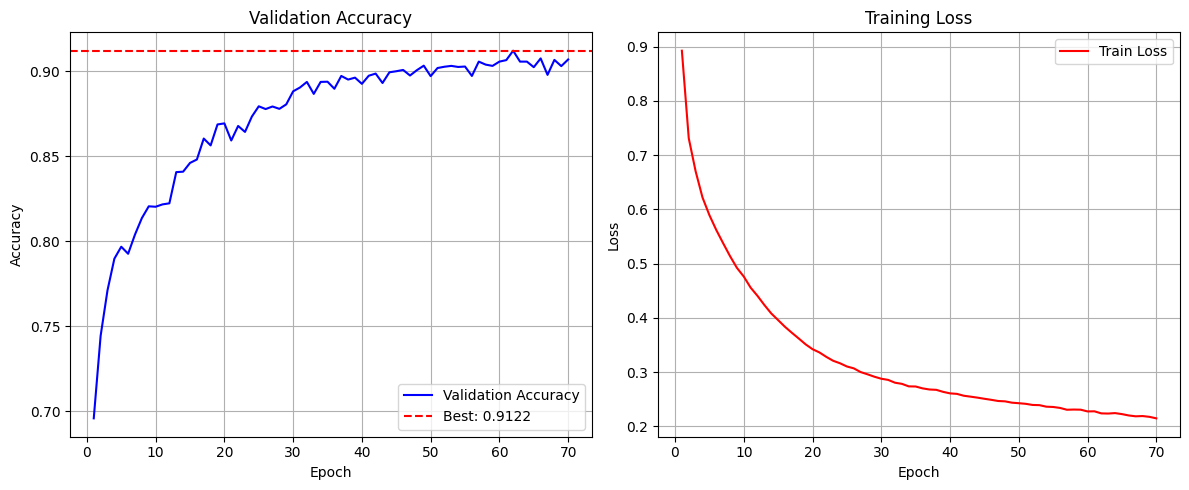

In [115]:
main()

In [15]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--train_csv', default='homeworks/hw1/data/train.csv')
    parser.add_argument('--val_csv', default='homeworks/hw1/data/val.csv')
    parser.add_argument('--test_csv', default='homeworks/hw1/data/test.csv')
    parser.add_argument('--out_csv', default='homeworks/hw1/data/submission.csv')
    parser.add_argument('--lr', default=0)
    parser.add_argument('--batch_size', default=0)
    parser.add_argument('--num_epoches', default=0)

    args = parser.parse_args()
    main(args)

usage: colab_kernel_launcher.py [-h] [--train_csv TRAIN_CSV]
                                [--val_csv VAL_CSV] [--test_csv TEST_CSV]
                                [--out_csv OUT_CSV] [--lr LR]
                                [--batch_size BATCH_SIZE]
                                [--num_epoches NUM_EPOCHES]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-e94a64b1-e464-47ad-b114-2efd2029f569.json


SystemExit: 2

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
